# Week 4 Project: Natural Language Processing with Disaster Tweets Kaggle Mini-Project

## Step 1: Data and Problem Statement
For this project I will be using data from:

Addison Howard, devrishi, Phil Culliton, and Yufeng Guo. Natural Language Processing with Disaster Tweets. https://kaggle.com/competitions/nlp-getting-started, 2019. Kaggle.

Recurrent Neural Networks will be used as they were the focus of this week's lecture content. The goal is to create models using Natural Language Processing that predicts which Tweets are about real disasters and which one’s are not.

### Setup
Imports and Installations

In [7]:
!pip install tensorflow

In [392]:
!pip install wordcloud

In [388]:
import pandas as pd
from collections import Counter
from matplotlib import pyplot as plt
import os
import seaborn
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import train_test_split
import sys
import nltk
from nltk.corpus import stopwords
import re
from PIL import Image
from wordcloud import WordCloud
import tensorflow as tf
import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras import layers

In [390]:
nltk.download('stopwords')

In [10]:
print(tf.__version__)
keras.__version__

2.18.0


'3.6.0'

### Data
According to the Kaggle description:

Each sample in the train and test set has the following information:
* The text of a tweet
* A keyword from that tweet (although this may be blank!)
* The location the tweet was sent from (may also be blank)

Columns:
* id - a unique identifier for each tweet
* text - the text of the tweet
* location - the location the tweet was sent from (may be blank)
* keyword - a particular keyword from the tweet (may be blank)
* target - in train.csv only, this denotes whether a tweet is about a real disaster (1) or not (0)

In [43]:
## Load the train data

train_data_df = pd.read_csv("data/train.csv")
print(f"Class distribution: {Counter(train_data_df.target)} \n")
print(train_data_df.info(), '\n')
train_data_df

Class distribution: Counter({0: 4342, 1: 3271}) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB
None 



,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


In [404]:
print(f"Class distribution ratio: {4342/3271:.4}")

Class distribution ratio: 1.327


The training data is composed of 7613 tweets. The class distribution is 4342 at label 0 (no disaster) and 3271 at label 1 (yes disaster), resulting in an approximate 1.327:1 ratio of non disaster to disaster mentioned tweets.

In [39]:
## Load the test data

test_df = pd.read_csv("data/test.csv")
print(test_df.info(), '\n')
test_df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB
None 



,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan
...,...,...,...,...
3258,10861,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...
3259,10865,NaN,NaN,Storm in RI worse than last hurricane. My city...
3260,10868,NaN,NaN,Green Line derailment in Chicago http://t.co/U...
3261,10874,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) htt...


The test data is composed of 3263 tweets. This dataset does not have labels and is just to be used to predict against for results to submit to the Kaggle competition.

## Step 2: Exploratory Data Analysis
Data will be inspected, analyzed, and cleaned as required.

I will start by preprocessing the dataframe to remove the uneeded id, keyword, and location columns. Afterwards, the actual tweet text will be transformed through stopword removal. Furthermore, non-english characters and special characters (such as those seen in the below example) will be cleaned.

Note: Text preprocessing will be done for both the train and test datasets.

In [91]:
print(test_df.query("id == 10861").text.iloc[0])

EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTENERS XrWn


In [98]:
## Helper function to clean the text

def remove_special_chars(text):
    text = re.sub(r'[^\x00-\x7F]+', '', text)  # Remove non - ASCII characters
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text) # Remove special characters except spaces
    return text

In [137]:
## Remove uneeded columns from dataset and stopwords from the tweets, train data

train_data_cleaned_df = train_data_df.copy()
train_data_cleaned_df = train_data_cleaned_df.drop(columns = (["id", "keyword", "location"]))
train_data_cleaned_df['text'] = train_data_cleaned_df['text'].str.lower()
stop = stopwords.words('english')
train_data_cleaned_df['text'] = train_data_cleaned_df['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
train_data_cleaned_df['text'] = train_data_cleaned_df['text'].apply(remove_special_chars)
train_data_cleaned_df

,text,target
0,deeds reason earthquake may allah forgive us,1
1,forest fire near la ronge sask canada,1
2,residents asked shelter place notified officer...,1
3,13000 people receive wildfires evacuation orde...,1
4,got sent photo ruby alaska smoke wildfires pou...,1
...,...,...
7608,two giant cranes holding bridge collapse nearb...,1
7609,ariaahrary thetawniest control wild fires cali...,1
7610,m194 0104 utc5km volcano hawaii httptcozdtoyd8ebj,1
7611,police investigating ebike collided car little...,1


In [139]:
## Clean the test dataset, remove uneeded columns from dataset while keeping the id column for Kaggle

test_data_cleaned_df = test_df.copy()
test_data_cleaned_df = test_data_cleaned_df.drop(columns = (["keyword", "location"]))
test_data_cleaned_df['text'] = test_data_cleaned_df['text'].str.lower()
stop = stopwords.words('english')
test_data_cleaned_df['text'] = test_data_cleaned_df['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
test_data_cleaned_df['text'] = test_data_cleaned_df['text'].apply(remove_special_chars)
test_data_cleaned_df

,id,text
0,0,happened terrible car crash
1,2,heard earthquake different cities stay safe ev...
2,3,forest fire spot pond geese fleeing across str...
3,9,apocalypse lighting spokane wildfires
4,11,typhoon soudelor kills 28 china taiwan
...,...,...
3258,10861,earthquake safety los angeles safety fastener...
3259,10865,storm ri worse last hurricane cityamp3others h...
3260,10868,green line derailment chicago httptcoutbxlcbiuy
3261,10874,meg issues hazardous weather outlook hwo httpt...


In [444]:
print(test_data_cleaned_df.query("id == 10861").text.iloc[0])

earthquake safety los angeles  safety fasteners xrwn


Examine the train data.

In [161]:
# Combine all text data into a single string
all_text = ' '.join(train_data_cleaned_df['text'].astype(str))

# Tokenize the text and count word frequencies
word_counts = Counter(all_text.split())

# Get the top 10 most frequent words
top_10_words = word_counts.most_common(10)

# Print the top 10 words and their frequencies
for word, count in top_10_words:
  print(f"{word}: {count}")

like: 345
im: 306
amp: 298
fire: 252
get: 229
new: 226
via: 220
people: 196
news: 194
one: 193


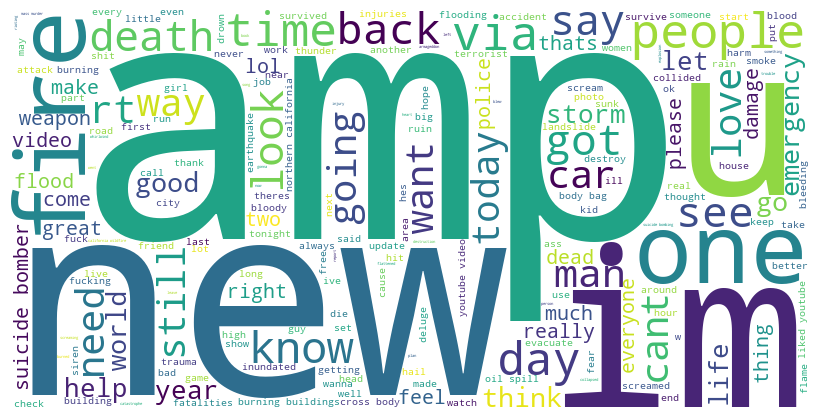

In [165]:
## Display a word cloud

wordcloud = WordCloud(width = 800, height = 400, background_color = 'white').generate(all_text)
plt.figure(figsize = (8, 5), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

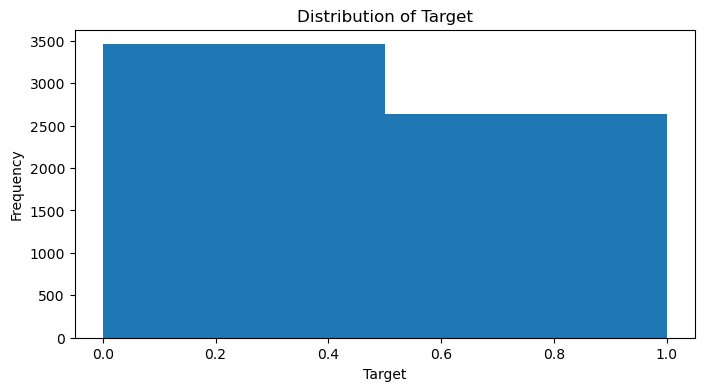

In [194]:
plt.figure(figsize = (8, 4))
plt.hist(train_df['target'], bins = 2)
plt.xlabel('Target')
plt.ylabel('Frequency')
plt.title('Distribution of Target')
plt.show()

Since the Kaggle test dataset does not contain labels and is only used for project submisson, a validation data set for supervised classification will need to be made with the training data. I will use a 80%-20% split, setting random_state to 0 for reproducibility.

In [242]:
## Prepare the train data for the RNN models

X = train_data_cleaned_df['text']
y = train_data_cleaned_df['target']

tokenizer = Tokenizer(num_words = 5000)
tokenizer.fit_on_texts(X)
X_seq = tokenizer.texts_to_sequences(X)
X_pad = pad_sequences(X_seq)

X_train, X_test, y_train, y_test = train_test_split(X_pad, y, test_size = 0.2, random_state = 0)

In [222]:
print(f"Number of observations: {X_train.shape[0]}")
X_train

Number of observations: 6090


array([[    0,     0,     0, ...,  3010,    11,  9528],
       [    0,     0,     0, ...,    41,  5932, 15270],
       [    0,     0,     0, ...,    66, 13183,   537],
       ...,
       [    0,     0,     0, ..., 10081, 10082, 10083],
       [    0,     0,     0, ...,  1308,   571,   255],
       [    0,     0,     0, ...,  2548,   192,   219]], dtype=int32)

In [224]:
print(f"Number of observations: {X_test.shape[0]}")
X_test

Number of observations: 1523


array([[    0,     0,     0, ...,    38,   989,   306],
       [    0,     0,     0, ..., 17276, 17277,  6255],
       [    0,     0,     0, ...,  7722,  7723,  7724],
       ...,
       [    0,     0,     0, ...,   501,    25,   117],
       [    0,     0,     0, ...,  5207,  1155,   409],
       [    0,     0,     0, ...,  3211, 12696, 12697]], dtype=int32)

In [331]:
## Prepare the test data for the RNN models

X_test_seq = tokenizer.texts_to_sequences(test_data_cleaned_df['text'])
X_test_pad = pad_sequences(X_test_seq)

In [333]:
print(f"Number of observations: {X_test_pad.shape[0]}")
X_test_pad

Number of observations: 3263


array([[   0,    0,    0, ..., 1818,   52,   21],
       [   0,    0,    0, ...,  505, 1910,  139],
       [   0,    0,    0, ...,  610, 1278,  239],
       ...,
       [   0,    0,    0, ...,  601,  245, 1179],
       [   0,    0,    0, ...,  153, 1610, 1790],
       [   0,    0,    0, ..., 1477,   14,  165]], dtype=int32)

## Steps 3-4: Model Architecture, Results, and Analysis
In this section deeplearning RNN models will be created, trained, and evaluated. Simple RNN, LSTM, and GRU architectures will be used. Also, some other hyperparemeters such as the number of epochs, loss, and optimzer will be tuned for comparison. For the most part, parameters will stay consistent with model 1 for the best comparison. The models used will include:
1. Simple RNN.
2. Simple RNN with adamw optimizer instead of adam.
3. LSTM.
4. LSTM with 5 epochs instead of 10.
5. GRU.
6. GRU with hinge loss instead of binary crossentropy.

The purpose of these architecture choices is to compare the performance of these parameters and methods used in class lectures.

#### Model 1: RNN

In [450]:
## Build the Simple RNN model

model = keras.Sequential([
    layers.Embedding(5000, 64),  # Embedding layer
    layers.SimpleRNN(128),  # SimpleRNN layer
    layers.Dense(1, activation='sigmoid')  # Output layer
])

model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

history = model.fit(X_train,
                    y_train,
                    epochs = 10,
                    batch_size = 64,
                    validation_split = 0.2
                    )

print("Results:")
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Validation Loss: {loss:.4f}")
print(f"Validation Accuracy: {accuracy:.4f}")

Epoch 1/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5845 - loss: 0.6694 - val_accuracy: 0.7053 - val_loss: 0.5773
Epoch 2/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8621 - loss: 0.3740 - val_accuracy: 0.7521 - val_loss: 0.5750
Epoch 3/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9505 - loss: 0.1494 - val_accuracy: 0.6913 - val_loss: 0.6683
Epoch 4/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9715 - loss: 0.1103 - val_accuracy: 0.7430 - val_loss: 0.6770
Epoch 5/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9742 - loss: 0.0839 - val_accuracy: 0.7184 - val_loss: 0.7316
Epoch 6/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9717 - loss: 0.0830 - val_accuracy: 0.7537 - val_loss: 0.7994
Epoch 7/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9812 - loss: 0.0650 - val_accuracy: 0.7488 - val_loss: 0.8300
Epoch 8/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9812 - loss: 0.0645 - val_accuracy: 0.7167 - val_loss:

In [452]:
model.summary()

Model: "sequential_31"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_29 (Embedding)        │ (None, 21, 64)         │       320,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_11 (SimpleRNN)       │ (None, 128)            │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,034,501 (3.95 MB)

 Trainable params: 344,833 (1.32 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 689,668 (2.63 MB)

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


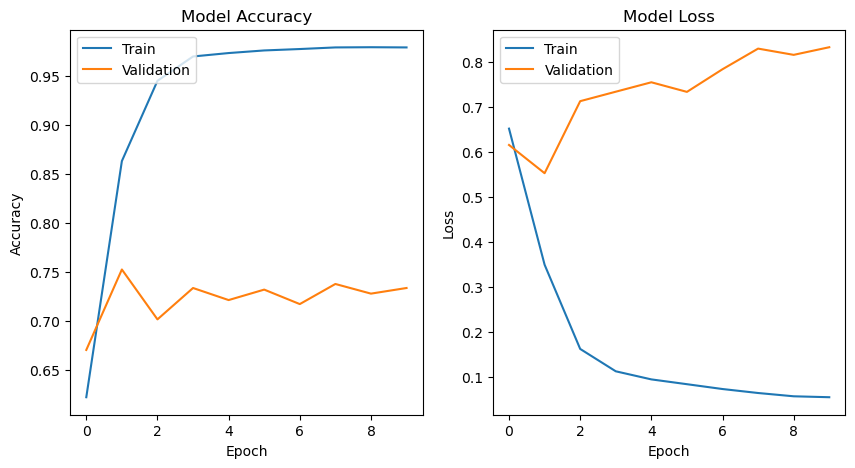

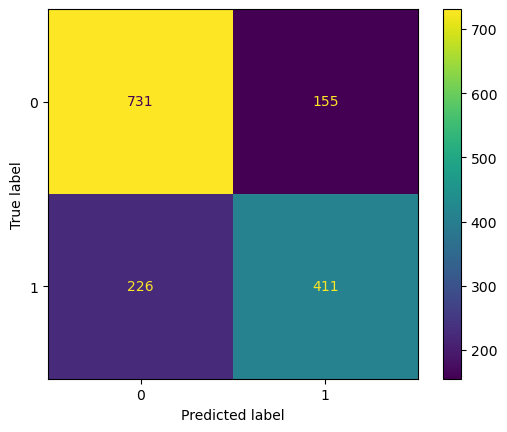

              precision    recall  f1-score   support

           0       0.76      0.83      0.79       886
           1       0.73      0.65      0.68       637

    accuracy                           0.75      1523
   macro avg       0.74      0.74      0.74      1523
weighted avg       0.75      0.75      0.75      1523



In [324]:
## Visualize the model performance over the epochs and generate results on the test data.

plt.figure(figsize=(10, 5))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Generate confusion matrix and classification report
y_pred = (model.predict(X_test) > 0.5).astype("int32")
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()
print(classification_report(y_test, y_pred))

The resulting Simple RNN architecture gives an f1-score of 0.73. The model trains quickly, though based on the history plots, overfits on the train data within a couple of epochs.

In [341]:
predictions = model.predict(X_test_pad)
results = pd.DataFrame({'id': test_df['id'], 'target': predictions.flatten()})
results['target'] = (results['target'] > 0.5).astype(int)
results.to_csv('results/model1_simplernn.csv', index=False)

102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 821us/step


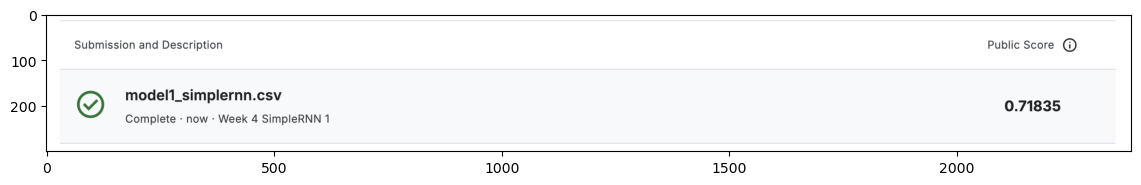

In [414]:
img = Image.open("results/simplernn1.png")
plt.figure(figsize=(14, 14))
plt.imshow(img)

#### Model 2: RNN

In [460]:
## Build the Simple RNN model, using a adamw optimizer to attempt to handle overfitting

model = keras.Sequential([
    layers.Embedding(5000, 64),  # Embedding layer
    layers.SimpleRNN(128),  # SimpleRNN layer
    layers.Dense(1, activation='sigmoid')  # Output layer
])

model.compile(loss = 'binary_crossentropy', optimizer = 'adamw', metrics = ['accuracy'])

history = model.fit(X_train,
                    y_train,
                    epochs = 10,
                    batch_size = 64,
                    validation_split = 0.2
                    )

print("Results:")
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Validation Loss: {loss:.4f}")
print(f"Validation Accuracy: {accuracy:.4f}")

Epoch 1/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5892 - loss: 0.6627 - val_accuracy: 0.7693 - val_loss: 0.5105
Epoch 2/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8596 - loss: 0.3539 - val_accuracy: 0.7069 - val_loss: 0.5917
Epoch 3/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9489 - loss: 0.1771 - val_accuracy: 0.7438 - val_loss: 0.6447
Epoch 4/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9662 - loss: 0.1118 - val_accuracy: 0.7430 - val_loss: 0.6643
Epoch 5/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9781 - loss: 0.0788 - val_accuracy: 0.7537 - val_loss: 0.7452
Epoch 6/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9800 - loss: 0.0696 - val_accuracy: 0.7553 - val_loss: 0.7013
Epoch 7/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9785 - loss: 0.0712 - val_accuracy: 0.7422 - val_loss: 0.8053
Epoch 8/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9812 - loss: 0.0672 - val_accuracy: 0.7685 - val_loss

In [461]:
model.summary()

Model: "sequential_33"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_31 (Embedding)        │ (None, 21, 64)         │       320,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_13 (SimpleRNN)       │ (None, 128)            │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,034,501 (3.95 MB)

 Trainable params: 344,833 (1.32 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 689,668 (2.63 MB)

48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


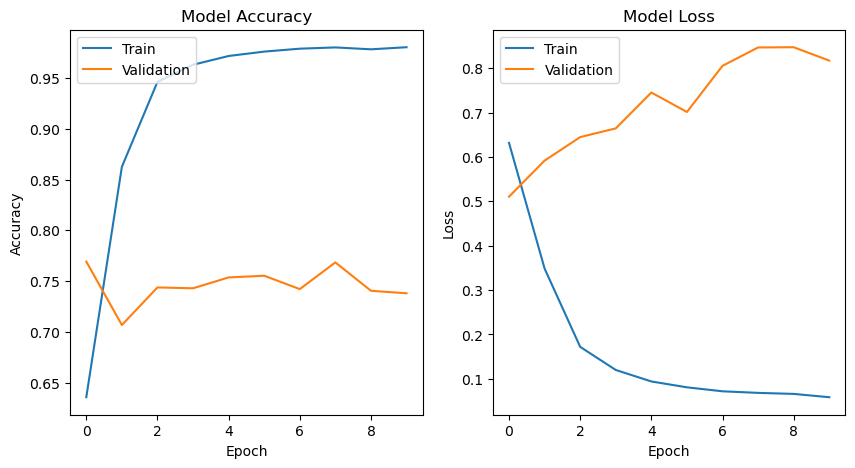

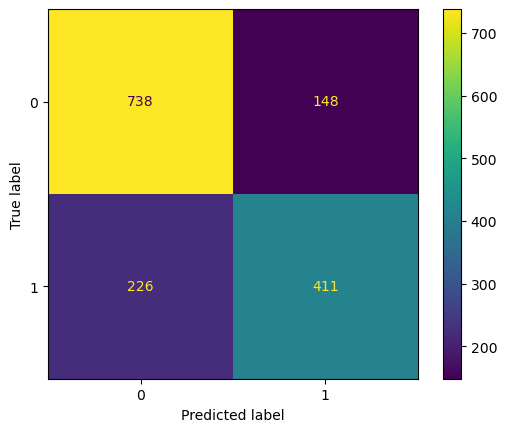

              precision    recall  f1-score   support

           0       0.77      0.83      0.80       886
           1       0.74      0.65      0.69       637

    accuracy                           0.75      1523
   macro avg       0.75      0.74      0.74      1523
weighted avg       0.75      0.75      0.75      1523



In [462]:
## Visualize the model performance over the epochs and generate results on the test data.

plt.figure(figsize=(10, 5))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Generate confusion matrix and classification report
y_pred = (model.predict(X_test) > 0.5).astype("int32")
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()
print(classification_report(y_test, y_pred))

The resulting Simple RNN architecture gives an f1-score of 0.75. Based on the history plots, this model also overfits on the train data fairly quickly, although the AdamW optimizer appears to have slighlty increased the performance.

In [347]:
predictions = model.predict(X_test_pad)
results = pd.DataFrame({'id': test_df['id'], 'target': predictions.flatten()})
results['target'] = (results['target'] > 0.5).astype(int)
results.to_csv('results/model2_simplernn.csv', index=False)

102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 654us/step


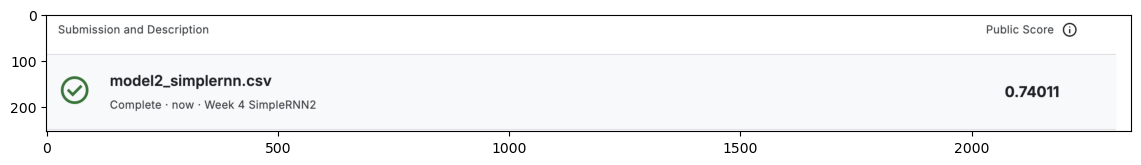

In [416]:
img = Image.open("results/simplernn2.png")
plt.figure(figsize=(14, 14))
plt.imshow(img)

#### Model 3: LSTM

In [466]:
## Build the LSTM model

model = keras.Sequential([
    layers.Embedding(5000, 64),
    layers.LSTM(128),  # GRU layer
    layers.Dense(1, activation = 'sigmoid')
])

model.compile(loss = 'binary_crossentropy', optimizer=  'adam', metrics = ['accuracy'])

history = model.fit(X_train,
                    y_train,
                    epochs = 10,
                    batch_size = 64,
                    validation_split = 0.2
                    )

loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

Epoch 1/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.5950 - loss: 0.6574 - val_accuracy: 0.7980 - val_loss: 0.4747
Epoch 2/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8572 - loss: 0.3500 - val_accuracy: 0.7939 - val_loss: 0.4759
Epoch 3/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8977 - loss: 0.2543 - val_accuracy: 0.7874 - val_loss: 0.5387
Epoch 4/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9308 - loss: 0.1908 - val_accuracy: 0.7545 - val_loss: 0.5921
Epoch 5/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9483 - loss: 0.1526 - val_accuracy: 0.7447 - val_loss: 0.7143
Epoch 6/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9588 - loss: 0.1196 - val_accuracy: 0.7512 - val_loss: 0.8303
Epoch 7/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9684 - loss: 0.0992 - val_accuracy: 0.7414 - val_loss: 0.8596
Epoch 8/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9736 - loss: 0.0789 - val_accuracy: 0.7537 - v

In [467]:
model.summary()

Model: "sequential_34"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_32 (Embedding)        │ (None, 21, 64)         │       320,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,256,837 (4.79 MB)

 Trainable params: 418,945 (1.60 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 837,892 (3.20 MB)

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


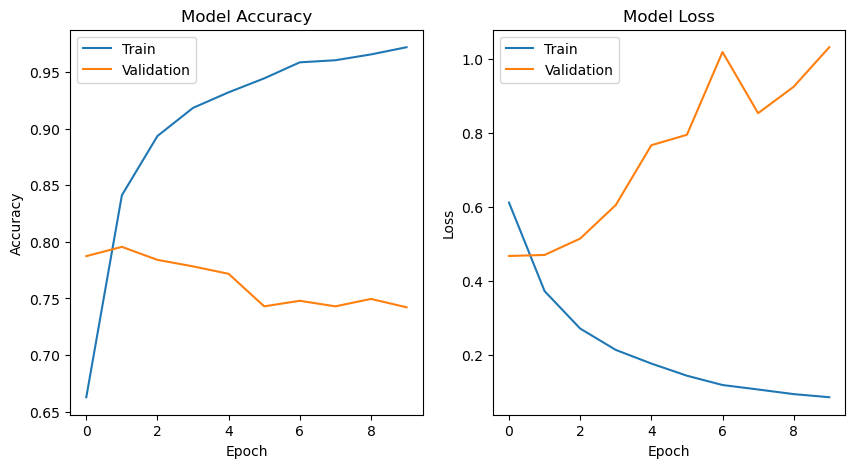

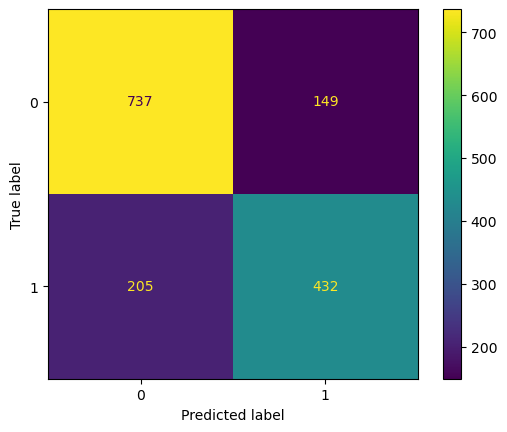

              precision    recall  f1-score   support

           0       0.78      0.83      0.81       886
           1       0.74      0.68      0.71       637

    accuracy                           0.77      1523
   macro avg       0.76      0.76      0.76      1523
weighted avg       0.77      0.77      0.77      1523



In [351]:
## Visualize the model performance over the epochs and generate results on the test data.

plt.figure(figsize=(10, 5))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Generate confusion matrix and classification report
y_pred = (model.predict(X_test) > 0.5).astype("int32")
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()
print(classification_report(y_test, y_pred))

The resulting LSTM architecture gives an f1-score of 0.75, although is relatively slower to train. Based on the history plots, this model also overfits quickly on the train data.

In [354]:
predictions = model.predict(X_test_pad)
results = pd.DataFrame({'id': test_df['id'], 'target': predictions.flatten()})
results['target'] = (results['target'] > 0.5).astype(int)
results.to_csv('results/model3_lstm.csv', index=False)

102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


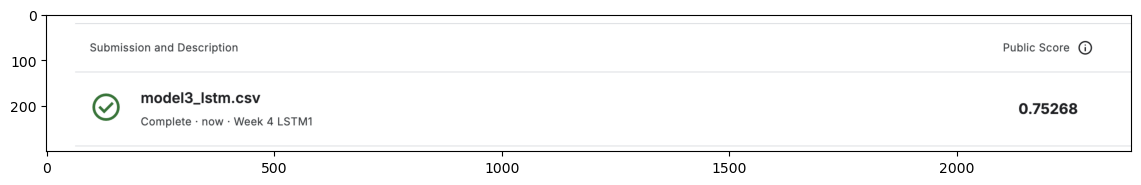

In [418]:
img = Image.open("results/lstm1.png")
plt.figure(figsize=(14, 14))
plt.imshow(img)

#### Model 4: LSTM

In [470]:
## Build the LSTM model, using 5 epochs instead of 10

model = keras.Sequential([
    layers.Embedding(5000, 64),
    layers.LSTM(128),  # GRU layer
    layers.Dense(1, activation = 'sigmoid')
])

model.compile(loss = 'binary_crossentropy', optimizer=  'adam', metrics = ['accuracy'])

history = model.fit(X_train,
                    y_train,
                    epochs = 5,
                    batch_size = 64,
                    validation_split = 0.2
                    )

loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

Epoch 1/5
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.6036 - loss: 0.6590 - val_accuracy: 0.7865 - val_loss: 0.4650
Epoch 2/5
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8503 - loss: 0.3620 - val_accuracy: 0.7874 - val_loss: 0.4695
Epoch 3/5
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9045 - loss: 0.2638 - val_accuracy: 0.7865 - val_loss: 0.5410
Epoch 4/5
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9294 - loss: 0.1851 - val_accuracy: 0.7709 - val_loss: 0.6120
Epoch 5/5
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9445 - loss: 0.1555 - val_accuracy: 0.7504 - val_loss: 0.6817
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7827 - loss: 0.6063
Test Loss: 0.6301
Test Accuracy: 0.7768


In [471]:
model.summary()

Model: "sequential_35"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_33 (Embedding)        │ (None, 21, 64)         │       320,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,256,837 (4.79 MB)

 Trainable params: 418,945 (1.60 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 837,892 (3.20 MB)

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


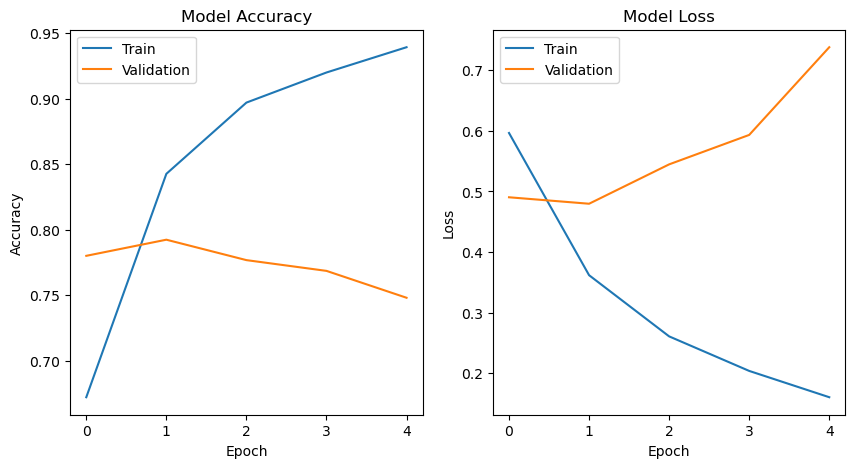

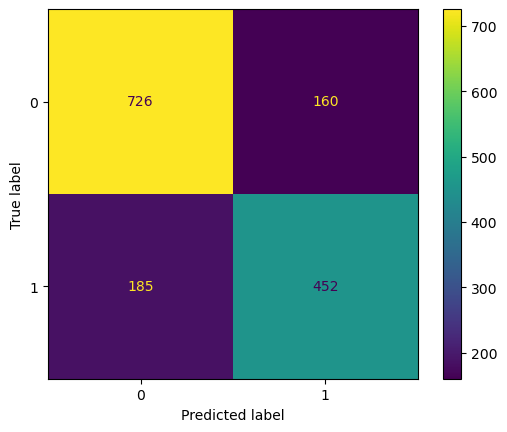

              precision    recall  f1-score   support

           0       0.80      0.82      0.81       886
           1       0.74      0.71      0.72       637

    accuracy                           0.77      1523
   macro avg       0.77      0.76      0.77      1523
weighted avg       0.77      0.77      0.77      1523



In [357]:
## Visualize the model performance over the epochs and generate results on the test data.

plt.figure(figsize=(10, 5))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Generate confusion matrix and classification report
y_pred = (model.predict(X_test) > 0.5).astype("int32")
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()
print(classification_report(y_test, y_pred))

The resulting LSTM architecture gives an f1-score of 0.78, a 3% improvement by using a reduced number of epochs. However, based on the plots a simple 1 epoch would likely give the best score.

In [360]:
predictions = model.predict(X_test_pad)
results = pd.DataFrame({'id': test_df['id'], 'target': predictions.flatten()})
results['target'] = (results['target'] > 0.5).astype(int)
results.to_csv('results/model4_lstm.csv', index=False)

102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


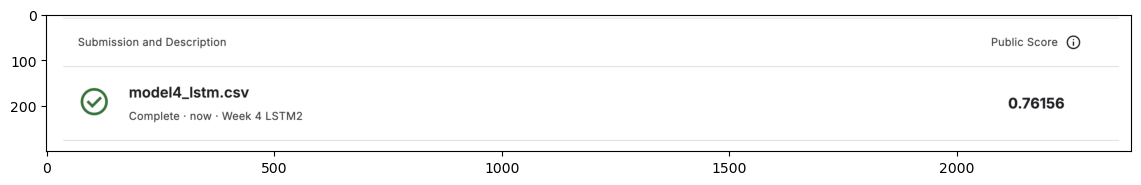

In [420]:
img = Image.open("results/lstm2.png")
plt.figure(figsize=(14, 14))
plt.imshow(img)

#### Model 5: GRU

In [474]:
## Build the GRU model

model = keras.Sequential([
    layers.Embedding(5000, 64),
    layers.GRU(128, activation = 'relu'),
    layers.Dense(1, activation = 'sigmoid')
])

model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

history = model.fit(X_train,
                    y_train,
                    epochs = 10,
                    batch_size = 64,
                    validation_split = 0.2
                    )

loss, accuracy = model.evaluate(X_test, y_test)
print(f"Validation Loss: {loss:.4f}")
print(f"Validation Accuracy: {accuracy:.4f}")

Epoch 1/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.5750 - loss: 0.6701 - val_accuracy: 0.7701 - val_loss: 0.4992
Epoch 2/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8419 - loss: 0.3764 - val_accuracy: 0.7865 - val_loss: 0.4795
Epoch 3/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8939 - loss: 0.2602 - val_accuracy: 0.7677 - val_loss: 0.5777
Epoch 4/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9270 - loss: 0.1960 - val_accuracy: 0.7496 - val_loss: 0.6202
Epoch 5/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9438 - loss: 0.1549 - val_accuracy: 0.7603 - val_loss: 0.6599
Epoch 6/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9615 - loss: 0.1167 - val_accuracy: 0.7373 - val_loss: 0.8479
Epoch 7/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9741 - loss: 0.0867 - val_accuracy: 0.7332 - val_loss: 0.8647
Epoch 8/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9745 - loss: 0.0755 - val_accuracy: 0.7348 - v

In [475]:
model.summary()

Model: "sequential_36"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_34 (Embedding)        │ (None, 21, 64)         │       320,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_10 (GRU)                    │ (None, 128)            │        74,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,183,877 (4.52 MB)

 Trainable params: 394,625 (1.51 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 789,252 (3.01 MB)

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


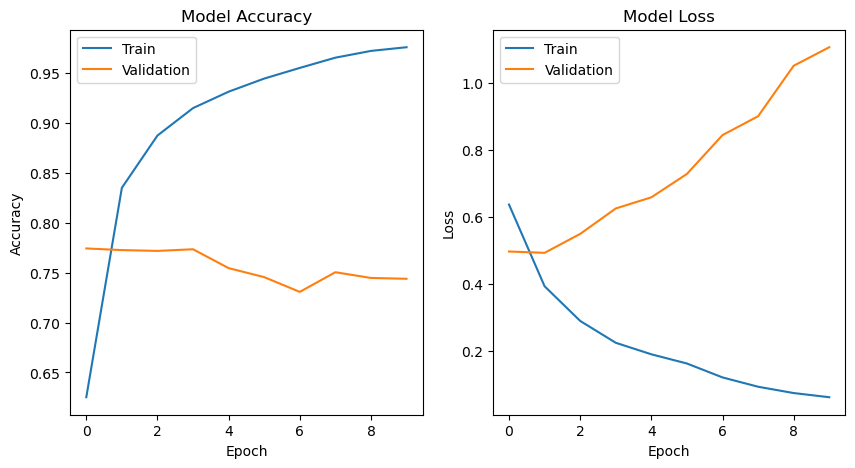

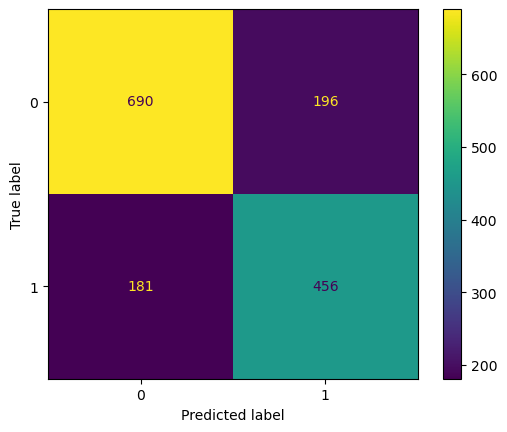

              precision    recall  f1-score   support

           0       0.79      0.78      0.79       886
           1       0.70      0.72      0.71       637

    accuracy                           0.75      1523
   macro avg       0.75      0.75      0.75      1523
weighted avg       0.75      0.75      0.75      1523



In [363]:
## Visualize the model performance over the epochs and generate results on the test data.

plt.figure(figsize=(10, 5))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Generate confusion matrix and classification report
y_pred = (model.predict(X_test) > 0.5).astype("int32")
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()
print(classification_report(y_test, y_pred))

The resulting GRU architecture gives an f1-score of 0.76, this is the best of the 3 base models (models 1, 3, and 5 where hyperparameters are the same aside from layer). Again, based on the history plots, this model also overfits quickly on the train data.

In [366]:
predictions = model.predict(X_test_pad)
results = pd.DataFrame({'id': test_df['id'], 'target': predictions.flatten()})
results['target'] = (results['target'] > 0.5).astype(int)
results.to_csv('results/model5_gru.csv', index=False)

102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


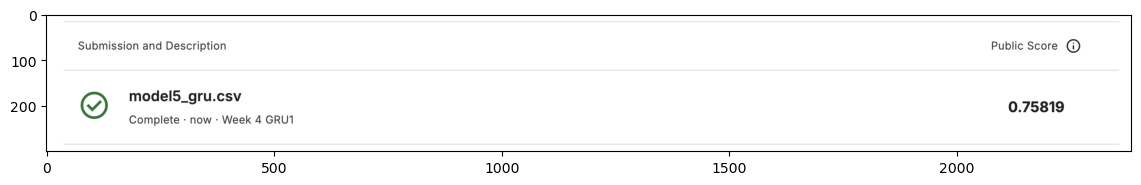

In [422]:
img = Image.open("results/gru1.png")
plt.figure(figsize=(14, 14))
plt.imshow(img)

#### Model 6: GRU

In [478]:
## Build the GRU model, this time using hinge loss

model = keras.Sequential([
    layers.Embedding(5000, 64),
    layers.GRU(128, activation = 'relu'),
    layers.Dense(1, activation = 'sigmoid')
])

model.compile(loss = 'hinge', optimizer = 'adam', metrics = ['accuracy'])

history = model.fit(X_train,
                    y_train,
                    epochs = 10,
                    batch_size = 64,
                    validation_split = 0.2
                    )

loss, accuracy = model.evaluate(X_test, y_test)
print(f"Validation Loss: {loss:.4f}")
print(f"Validation Accuracy: {accuracy:.4f}")

Epoch 1/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.5483 - loss: 1.0392 - val_accuracy: 0.5673 - val_loss: 1.0000
Epoch 2/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5649 - loss: 1.0000 - val_accuracy: 0.5673 - val_loss: 1.0000
Epoch 3/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.5639 - loss: 1.0000 - val_accuracy: 0.5673 - val_loss: 1.0000
Epoch 4/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.5657 - loss: 1.0000 - val_accuracy: 0.5673 - val_loss: 1.0000
Epoch 5/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.5630 - loss: 1.0000 - val_accuracy: 0.5673 - val_loss: 1.0000
Epoch 6/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.5649 - loss: 1.0000 - val_accuracy: 0.5673 - val_loss: 1.0000
Epoch 7/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.5601 - loss: 1.0000 - val_accuracy: 0.5673 - val_loss: 1.0000
Epoch 8/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.5731 - loss: 1.0000 - val_accuracy: 0.5673 - v

In [479]:
model.summary()

Model: "sequential_37"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_35 (Embedding)        │ (None, 21, 64)         │       320,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_11 (GRU)                    │ (None, 128)            │        74,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,183,877 (4.52 MB)

 Trainable params: 394,625 (1.51 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 789,252 (3.01 MB)

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


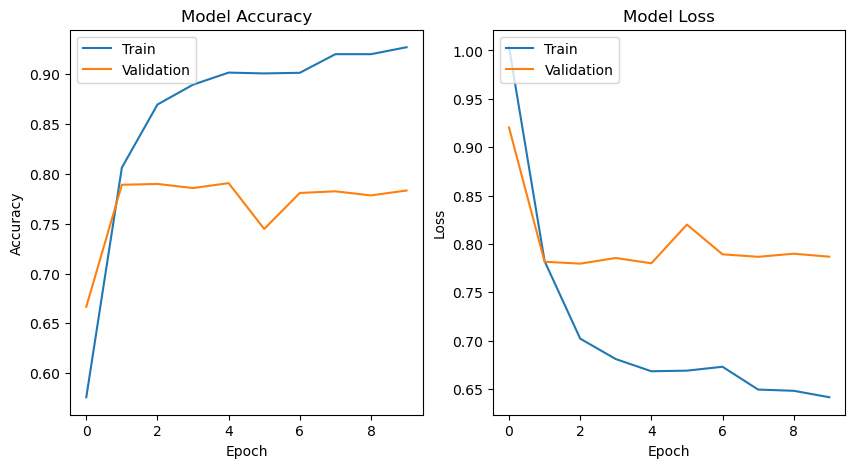

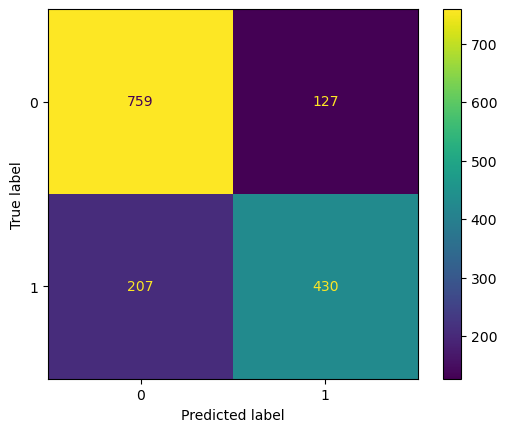

              precision    recall  f1-score   support

           0       0.79      0.86      0.82       886
           1       0.77      0.68      0.72       637

    accuracy                           0.78      1523
   macro avg       0.78      0.77      0.77      1523
weighted avg       0.78      0.78      0.78      1523



In [379]:
## Visualize the model performance over the epochs and generate results on the test data.

plt.figure(figsize=(10, 5))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Generate confusion matrix and classification report
y_pred = (model.predict(X_test) > 0.5).astype("int32")
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()
print(classification_report(y_test, y_pred))

The resulting GRU architecture gives an f1-score of 0.78 using hinge loss. Although the model is overfitting based on the increasing train performance, this time, the validation accuracy and loss levels off due to the change in loss function. While less epochs are needed, this approach keep performance the same.

In [380]:
predictions = model.predict(X_test_pad)
results = pd.DataFrame({'id': test_df['id'], 'target': predictions.flatten()})
results['target'] = (results['target'] > 0.5).astype(int)
results.to_csv('results/model6_gru.csv', index=False)

102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


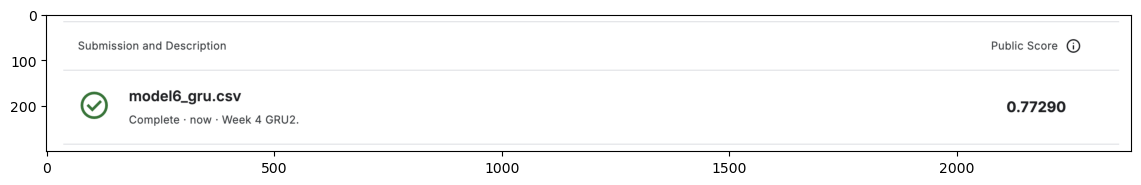

In [482]:
img = Image.open("results/gru2.png")
plt.figure(figsize=(14, 14))
plt.imshow(img)

## Step 5: Conclusion

Based on the results, the LSTM performed the best followed by GRU and then the Simple RNN. The models overfit on the data quickly, meaning a lower number of epochs produced a better model. Hingle loss midigated the decrease in validation performance when overfitting on training data. Finally, the adamw optimizer gave a slight increase in model performance over the default adam optimizer.

The best performing model was the LSTM using 5 epochs with Kaggle score of approximately 76.16%. Both the LSTM and GRU took longer to train than the Simple RNN. Future work could include changing how the text data is preprocessed. I used several cleaning techniques such as stopword removal. However, different approaches such as lemmatization or leaving it unlatered could produce different results. Also, using TF-IDF as the feature input instead of word embeddings would be worth trying.

More combintations of different loss functions, optimizers, epochs, and layer types / number of layers could possibly result in a better model. Further analyzing the Type 1 and Type 2 errors after a model has been trained can provide insights into what could have caused the misclassification. This post hoc analysis could then lead to tweaking the original models or even the input data to better fit the data. 

Lastly, using different architectures such as the Bidirectional LSTM could provide even more context than the LSTM since it takes into account context in the form of cell state in a forward and backward input sequence, rather than just forward. While out of scope of this class, LLMs would also be able to classify the tweets, especially with some prompt engineering where you feed some positive and negative examples.